In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import sklearn
from __future__ import print_function
import librosa
import numpy as np  
import matplotlib.pyplot as plt
from librosa import display,core
from dtw import dtw
from numpy import linalg as LA
from math import sqrt
from scipy import stats
from sklearn import svm
from sklearn.svm import SVR
from mlxtend.plotting import plot_decision_regions
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_predict, cross_val_score,cross_validate
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
#%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import time

In [2]:
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import os

def createTrainingData(start, end):
    samples = []
    telangana_dir = 'audio/Telangana'
    coastal_dir = 'audio/Coastal'
    rayalseema_dir = 'audio/Rayalseema'
    
    regions = {
        'Telangana': telangana_dir,
        'Coastal': coastal_dir,
        'Rayalseema':rayalseema_dir
    }

    for region, region_dir in regions.items():
        if region == 'Telangana':
            file_range = range(239, 357)
        elif region == 'Rayalseema':
            file_range = range(116, 215)
        elif region == 'Coastal':
            file_range = range(1, 102)  # Assuming audio files in Coastal are named from '1.wav' to '101.wav'

        for i in file_range:
            ind = 0
            try:
                file_path = os.path.join(region_dir, f"{i}.wav")
                a, s = librosa.load(file_path)
            except:
                ind = 1

            if ind == 0:
                mfcc = librosa.feature.mfcc(y=a, sr=s)
                temp = mfcc.T[1][start:end]
                for frame in range(10, 50):
                    temp = np.concatenate((temp, mfcc.T[frame][start:end]))
                samples.append([temp, region])

    print(len(samples))
    X = [i[0] for i in samples]
    Y = [j[1] for j in samples]
    return X, Y

data, label = createTrainingData(1, 19)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)


C:\Users\Lavanya Tetakali\AppData\Local\Temp\ipykernel_6132\4124688655.py:30: UserWarning: PySoundFile failed. Trying audioread instead.
  a, s = librosa.load(file_path)
C:\Users\Lavanya Tetakali\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


317


In [3]:
knn = LogisticRegression()
scores = cross_val_score(knn, data, label, cv=10, scoring='f1_macro')
scores.mean(),scores.std()              

(0.90739001485993, 0.07414735897457535)

In [4]:
Counter(label)

Counter({'Telangana': 118, 'Coastal': 100, 'Rayalseema': 99})

In [5]:
X_train, X_test, y_train, y_test  = train_test_split(data,label)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[('Coastal', 90), ('Rayalseema', 90), ('Telangana', 90)]


In [6]:
s=time.time()
g = LogisticRegression()
g.fit(X_train,y_train)
pred = g.predict(X_test)
print(time.time()-s)

0.11200213432312012


In [7]:
from sklearn.linear_model import LogisticRegression

def predict(X, Y, Z):
    log_reg = LogisticRegression()
    log_reg.fit(X, Y)
    prediction = log_reg.predict(Z)
    scores = cross_val_score(log_reg, data, label)  # You should have 'data' and 'label' defined somewhere in your code.
    print(scores.mean())
    return prediction


def printPrediction(prediction,actual_label):
    print("1 -> Telangana, 0-> Coastal, 2-> Rayalseema\n")
    for i in range(len(prediction)):
        print("Actual ->",actual_label[i]," Prediction ->",prediction[i])

def accuracy(prediction,actual):
    count=0
    l=len(prediction)
    for i in range(l):
        if(prediction[i]==actual[i]):
            count+=1
    return count/l*100

In [8]:
s= time.time()
pred = predict(X_resampled,y_resampled,X_test)
#printPrediction(prediction,y_train)
print(time.time()-s)
e = accuracy(pred,y_test)
print("\nAccuracy:",e)


0.8612103174603174
0.9002630710601807

Accuracy: 91.25


In [9]:
conf_matrix = confusion_matrix(y_test, pred)
conf_matrix
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
tp = conf_matrix[1, 1]


In [10]:
precision = round(tp/(tp+fp),4)
recall = round(tp/(tp+fn),4)
fmeasure = round(2*((precision*recall)/(precision+recall)),4)
rej = round(tn/(tn+fp),4)
acc = round((tn+tp)/(tn+tp+fp+fn),4)

In [11]:
print(precision,recall,fmeasure,rej,acc)

0.92 1.0 0.9583 0.9286 0.9608


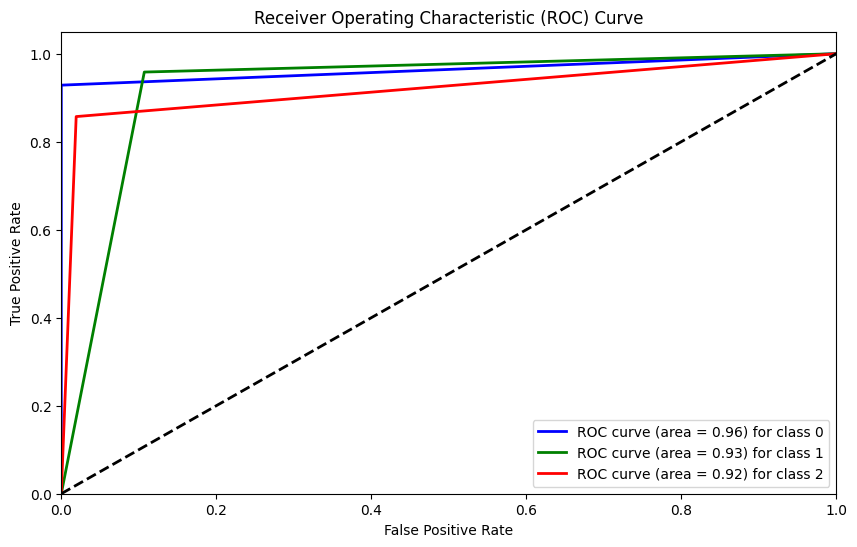

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming 'y_test' and 'pred' contain your actual labels and predicted labels
# Convert labels to binary (0 and 1) for one-vs-all ROC AUC curve
y_test_bin = label_binarize(y_test, classes=['Coastal', 'Rayalseema', 'Telangana'])
pred_bin = label_binarize(pred, classes=['Coastal', 'Rayalseema', 'Telangana'])

n_classes = y_test_bin.shape[1]

# Initialize variables to store the ROC curve and AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC AUC curves
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [13]:
from sklearn.metrics import classification_report

# Assuming 'y_test' contains the true labels and 'pred' contains the predicted labels
report = classification_report(y_test, pred)

# Print the classification report
print(report)


              precision    recall  f1-score   support

     Coastal       1.00      0.93      0.96        28
  Rayalseema       0.79      0.96      0.87        24
   Telangana       0.96      0.86      0.91        28

    accuracy                           0.91        80
   macro avg       0.92      0.91      0.91        80
weighted avg       0.92      0.91      0.91        80

